### Burgers' equation
Physics form:
$$\frac{\partial u(t,x)}{\partial t} + u(t,x) \frac{\partial u(t,x)}{\partial x} = \nu \frac{\partial^2 u(t,x)}{\partial x^2}$$
$u(t,x)$: velocity of fluid, $\nu$: viscosity of fluid <br><br>

General form:
$$\frac{\partial u(t,x)}{\partial t} + \lambda _{1} u(t,x) \frac{\partial u(t,x)}{\partial x} -\lambda _{2} \frac{\partial^2 u(t,x)}{\partial x^2} = 0$$<br>

In identification, the solution $u(x,t)$ is known and we want to discover the parameters of the equation $F(t, x, u(t, x), \lambda) = 0.$ This is a supervised task, the dataset is constituted of $N$ points, which are randomly selected in the entire space-time domain  $\Omega = [0, 1] \times [-1, 1]$, $S = \{t_i, x_i, u(t_i, x_i)\}_{i=1}^N$, this dataset gives the solution for every $(t, x) \in \Omega$. The information from the boundary & intial conditions is encoded in the dataset, $x \in [-1,1]$, $t \in [0,1]$ and $u(t,x)$ in the interior of $\Omega$. <br>

Define $f := u_t + \lambda _1 u u_x - \lambda _2 u_{xx}$, (link with $F$: $\lambda = (\lambda_1,\lambda_2)$), this will be an approximation of the PDE given by the PINN, ```u(t,x)``` approximation of the exact solution given by the PINN.

The loss is defined by: $MSE = MSE_f + MSE_u$, it is a combination of the PDE loss $MSE_f$ and the training data loss $MSE_u$. <br>
$MSE_f = \frac{1}{N}\Sigma_{i=1}^{N} |f(t_u^i,x_u^i)|^2$ <br>
$MSE_u = \frac{1}{N}\Sigma_{i=1}^{N} |u(t_u^i,x_u^i) - u^i|^2$ <br>

Where $\{t_u^i,x_u^i,u^i\}_{i=1}^{N}$ is the training dataset. ***Note*: here we use the same training set on both losses.**

Expected $\lambda$: $\lambda_1 = 1.0$ and $\lambda_2 = \frac{0.01}{\pi} \approx 0.00318$

### DNN

In [12]:
import torch
from torch import nn 
from collections import OrderedDict
torch.manual_seed(0)

class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(len(layers) - 2): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (len(layers) - 2), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)

        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

### PINN

In [29]:
import torch.optim as optim

class PINN():
    def __init__(self, layers, xt_train, u_train, tol=1e-5, hs=50, verbose=True): 
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.verbose = verbose
        if self.verbose:
            print(f"device used: {self.device}")
            print(f"xt_train shape: {xt_train.shape}")
            print(f"u_train shape: {u_train.shape}")
        
        self.x_tr = torch.tensor(xt_train[:, 0:1], requires_grad=True).float().to(self.device) 
        self.t_tr = torch.tensor(xt_train[:, 1:2], requires_grad=True).float().to(self.device) 
        self.u_tr = torch.tensor(u_train).float().to(self.device) 
        
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(self.device) #random guess
        self.lambda_2 = torch.tensor([-6.0], requires_grad=True).to(self.device) #random guess 
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        self.net = DNN(layers).to(self.device)
        self.net.register_parameter('lambda_1', self.lambda_1)
        self.net.register_parameter('lambda_2', self.lambda_2)
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
        
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=hs,
            tolerance_grad=tol, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"    
        )
        
        self.iter = 1
        
    def net_u(self, x, t): #get u(x,t) for a pair (x,t); a forward pass through the PINN
        u = self.net(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = self.lambda_1        
        lambda_2 = torch.exp(self.lambda_2)
        
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx
        return f

    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_tr, self.t_tr) #100, 1; all the ic/bc pairs were feeded through the PINN
        f_pred = self.net_f(self.x_tr, self.t_tr) #10456, 1; all the collocations points were feeded through the PINN
        
        loss_u = torch.mean((self.u_tr - u_pred) ** 2) #MSE loss on the ic/bc pairs, MSE loss on trainset, classic NN
        loss_f = torch.mean(f_pred ** 2) #MSE loss on the collocations pairs, regularization term
        
        loss = loss_u + loss_f #classic loss + regularization loss (enforce the PDE structure) => PINN loss
        
        loss.backward() #backpropagation
        
        self.iter += 1
        if self.verbose:
            if self.iter % 100 == 0:
                print(
                    'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e, Lambda1: %.5f, Lambda2: %.5f' % (self.iter, loss.item(), loss_u.item(), loss_f.item(), self.lambda_1.item(), torch.exp(self.lambda_2.detach()).item())
                )
        return loss
    
    def train(self):
        self.net.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, xt):
        x = torch.tensor(xt[:, 0:1], requires_grad=True).float().to(self.device) #get x from pair
        t = torch.tensor(xt[:, 1:2], requires_grad=True).float().to(self.device) #get t from pair

        self.net.eval()
        
        u = self.net_u(x, t) 
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

### Data Generation

In [30]:
import scipy.io
import numpy as np
import time

lambda_1_true = 1.0
lambda_2_true = 0.01/np.pi
Nu = 2000 #max 25600

sol_data = scipy.io.loadmat('burgers_shock.mat')
x_sol = sol_data['x'].flatten()[:,None]
t_sol = sol_data['t'].flatten()[:,None]
U_sol = np.real(sol_data['usol']).T
X, T = np.meshgrid(x_sol, t_sol)
xt_sol = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_sol = U_sol.flatten()[:,None]              
lower_bound_domain = xt_sol.min(0)
upper_bound_domain = xt_sol.max(0) 

idx = np.random.choice(xt_sol.shape[0], Nu, replace=False)
xt_train = xt_sol[idx,:]
u_train = u_sol[idx,:]

### Create and train

In [31]:
%%time

nb_nodes = 20
nb_hidden_layers = 9
layers = np.hstack([np.array([2]),np.full(nb_hidden_layers, nb_nodes),np.array([1])])

model = PINN(layers, xt_train, u_train, tol=1e-5, hs=50)

model.train()

device used: cuda:0
xt_train shape: (2000, 2)
u_train shape: (2000, 1)
Iter 100, Loss: 2.11960e-02, Loss_u: 1.90205e-02, Loss_f: 2.17553e-03, Lambda1: 0.31728, Lambda2: 0.00229
Iter 200, Loss: 1.03934e-02, Loss_u: 7.93848e-03, Loss_f: 2.45490e-03, Lambda1: 0.61208, Lambda2: 0.00319
Iter 300, Loss: 4.66662e-03, Loss_u: 3.16448e-03, Loss_f: 1.50214e-03, Lambda1: 0.77490, Lambda2: 0.00365
Iter 400, Loss: 2.55524e-03, Loss_u: 1.23026e-03, Loss_f: 1.32498e-03, Lambda1: 0.88562, Lambda2: 0.00403
Iter 500, Loss: 1.17348e-03, Loss_u: 5.23097e-04, Loss_f: 6.50383e-04, Lambda1: 0.95834, Lambda2: 0.00440
Iter 600, Loss: 6.99925e-04, Loss_u: 3.03556e-04, Loss_f: 3.96369e-04, Lambda1: 0.97270, Lambda2: 0.00418
Iter 700, Loss: 3.75123e-04, Loss_u: 1.20312e-04, Loss_f: 2.54811e-04, Lambda1: 0.98675, Lambda2: 0.00378
Iter 800, Loss: 1.97118e-04, Loss_u: 4.92843e-05, Loss_f: 1.47834e-04, Lambda1: 0.98736, Lambda2: 0.00351
Iter 900, Loss: 1.38240e-04, Loss_u: 2.49061e-05, Loss_f: 1.13334e-04, Lambda1: 0

### Evaluate

In [33]:
def l2_norm(pred, true):
    return np.linalg.norm(true - pred,2)/np.linalg.norm(true, 2)

def mse(pred, true):
    return ((pred - true)**2).mean(axis=0).item()

u_pred, f_pred = model.predict(xt_sol)
lambda_1_pred = model.lambda_1.detach().cpu().numpy()
lambda_2_pred = model.lambda_2.detach().cpu().numpy()
lambda_2_pred = np.exp(lambda_2_pred)

l2_u = l2_norm(u_pred, u_sol)  
mse_u = mse(u_pred, u_sol)
mse_f = mse(f_pred, np.zeros(f_pred.shape))
relative_error_lambda_1 = np.abs(lambda_1_pred - lambda_1_true) * 100
relative_error_error_lambda_2 = np.abs(lambda_2_pred - lambda_2_true) / lambda_2_true * 100

print('L2 Error u: %e' % (l2_u)) 
print(f"MSE Error u: {mse_u}") 
print(f"MSE Error f: {mse_f}") 
print('Error l1: %.5f%%' % (relative_error_lambda_1))                             
print('Error l2: %.5f%%' % (relative_error_error_lambda_2))

L2 Error u: 5.458441e-04
MSE Error u: 1.1244788504631858e-07
MSE Error f: 5.3329003940706035e-05
Error l1: 0.01928%
Error l2: 0.06421%


### Plot

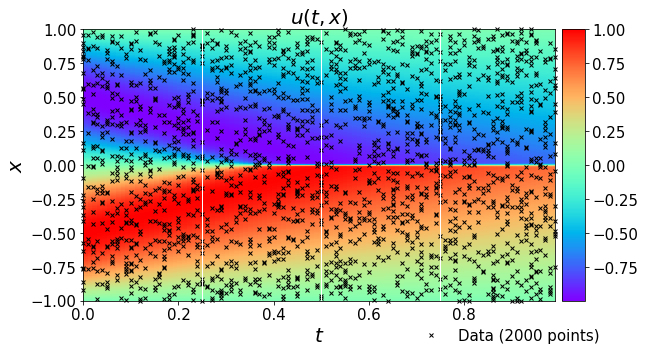

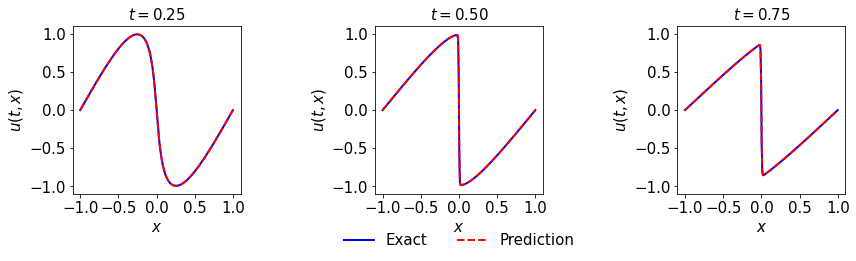

In [37]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

#first plot
U_pred = griddata(xt_sol, u_pred.flatten(), (X, T), method='cubic')

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t_sol.min(), t_sol.max(), x_sol.min(), x_sol.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    xt_train[:,1], 
    xt_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x_sol.min(), x_sol.max(), 2)[:,None]
ax.plot(t_sol[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_sol[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_sol[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()


#second plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)
ax.remove()

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x_sol,U_sol[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_sol,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x_sol,U_sol[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_sol,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x_sol,U_sol[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_sol,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

### Add Noise

In [34]:
%%time

noise = 0.01 #1% uncorrelated noise

u_train_noise = u_train + noise * np.std(u_train) * np.random.randn(u_train.shape[0], u_train.shape[1])

model = PINN(layers, xt_train, u_train_noise, tol=1e-5, hs=50)

model.train()

device used: cuda:0
xt_train shape: (2000, 2)
u_train shape: (2000, 1)
Iter 100, Loss: 1.88754e-02, Loss_u: 1.67195e-02, Loss_f: 2.15587e-03, Lambda1: 0.34855, Lambda2: 0.00201
Iter 200, Loss: 5.78386e-03, Loss_u: 3.36897e-03, Loss_f: 2.41489e-03, Lambda1: 0.70862, Lambda2: 0.00236
Iter 300, Loss: 2.07870e-03, Loss_u: 8.35888e-04, Loss_f: 1.24281e-03, Lambda1: 0.87608, Lambda2: 0.00293
Iter 400, Loss: 1.11989e-03, Loss_u: 3.77706e-04, Loss_f: 7.42184e-04, Lambda1: 0.92851, Lambda2: 0.00320
Iter 500, Loss: 6.75867e-04, Loss_u: 2.38285e-04, Loss_f: 4.37582e-04, Lambda1: 0.94240, Lambda2: 0.00334
Iter 600, Loss: 4.70567e-04, Loss_u: 1.35523e-04, Loss_f: 3.35044e-04, Lambda1: 0.96559, Lambda2: 0.00335
Iter 700, Loss: 3.38370e-04, Loss_u: 1.03837e-04, Loss_f: 2.34533e-04, Lambda1: 0.97912, Lambda2: 0.00338
Iter 800, Loss: 2.59110e-04, Loss_u: 9.09501e-05, Loss_f: 1.68159e-04, Lambda1: 0.98509, Lambda2: 0.00345
Iter 900, Loss: 1.97489e-04, Loss_u: 6.93093e-05, Loss_f: 1.28180e-04, Lambda1: 0

### Evaluate noise

In [36]:
u_noise_pred, f_noise_pred = model.predict(xt_sol)
lambda_1_noise_pred = model.lambda_1.detach().cpu().numpy()
lambda_2_noise_pred = model.lambda_2.detach().cpu().numpy()
lambda_2_noise_pred = np.exp(lambda_2_noise_pred)

l2_u_noise = l2_norm(u_noise_pred, u_sol)  
mse_u_noise = mse(u_noise_pred, u_sol)
mse_f_noise = mse(f_noise_pred, np.zeros(f_noise_pred.shape))
relative_error_lambda_1 = np.abs(lambda_1_noise_pred - lambda_1_true) * 100
relative_error_error_lambda_2 = np.abs(lambda_2_noise_pred - lambda_2_true) / lambda_2_true * 100

print('L2 Error u noise: %e' % (l2_u_noise)) 
print(f"MSE Error u noise: {mse_u_noise}") 
print(f"MSE Error f noise: {mse_f_noise}") 
print('Error l1 noise: %.5f%%' % (relative_error_lambda_1))                             
print('Error l2 noise: %.5f%%' % (relative_error_error_lambda_2))

L2 Error u noise: 1.283635e-03
MSE Error u noise: 6.218668916645782e-07
MSE Error f noise: 0.00010926905049711007
Error l1 noise: 0.01863%
Error l2 noise: 0.18544%


### Plot

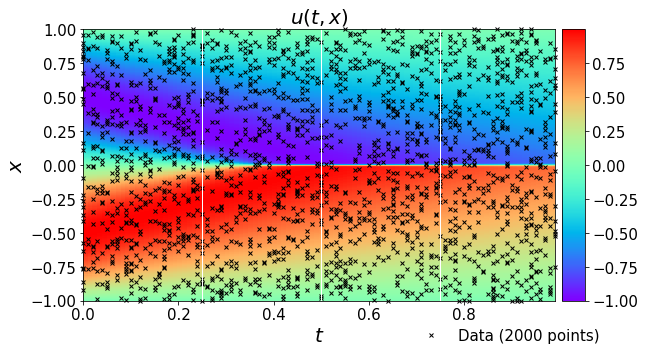

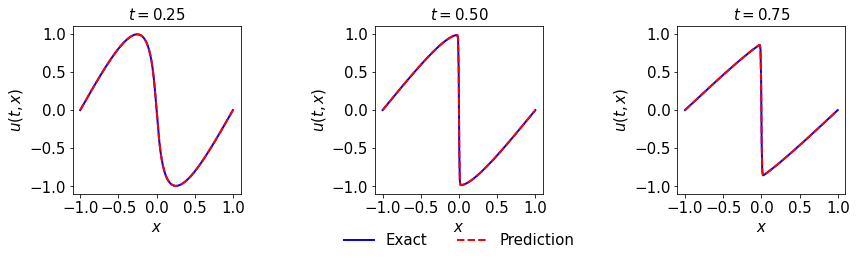

In [38]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

#first plot
U_pred = griddata(xt_sol, u_noise_pred.flatten(), (X, T), method='cubic')

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t_sol.min(), t_sol.max(), x_sol.min(), x_sol.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    xt_train[:,1], 
    xt_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x_sol.min(), x_sol.max(), 2)[:,None]
ax.plot(t_sol[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_sol[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_sol[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()


#second plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)
ax.remove()

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x_sol,U_sol[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_sol,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x_sol,U_sol[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_sol,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x_sol,U_sol[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_sol,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()